In [ ]:
import time

In [1]:
import numpy as np

In [2]:
import awkward as ak

In [3]:
import matplotlib.pyplot as plt

In [4]:
# http://millionsongdataset.com/pages/field-list/
songs = ak.from_parquet("~/storage/data/million-song-dataset/full/millionsongs", lazy=True)
songs

<Array [...] type='1000000 * {"hdf5_filename": string, "analysis": {"bars": var ...'>

In [5]:
key_shift = ak.Array([
    [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
    [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0],
    [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1],
    [ 3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2],
    [ 4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3],
    [ 5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4],
    [ 6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5],
    [ 7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6],
    [ 8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7],
    [ 9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8],
    [10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
    [11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
])

In [6]:
# some_songs = songs[:10000]
some_songs = ak.Array(songs.layout.partitions[0])

In [7]:
shift_for_song = key_shift[some_songs.analysis.key]

In [8]:
shifted_pitches = some_songs.analysis.segments.pitches[shift_for_song[:, np.newaxis]]

In [9]:
sorted_pitches = ak.argsort(shifted_pitches, axis=-1)

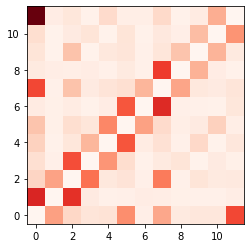

In [10]:
second_loudest = sorted_pitches[:, :, -2]
first_loudest = sorted_pitches[:, :, -1]

fig, ax = plt.subplots(1, 1)
ax.hist2d(
    np.asarray(ak.flatten(first_loudest)),
    np.asarray(ak.flatten(second_loudest)),
    bins=(12, 12),
    range=((-0.5, 11.5), (-0.5, 11.5)),
    cmap="Reds",
);
ax.set_aspect(1)

In [11]:
loudest_pitches = ak.argmax(shifted_pitches, axis=-1)

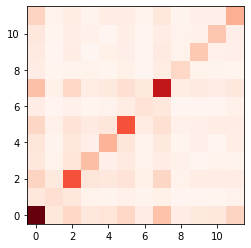

In [12]:
before = loudest_pitches[:, :-1]
after = loudest_pitches[:, 1:]

fig, ax = plt.subplots(1, 1)
ax.hist2d(
    np.asarray(ak.flatten(before)),
    np.asarray(ak.flatten(after)),
    bins=(12, 12),
    range=((-0.5, 11.5), (-0.5, 11.5)),
    cmap="Reds",
)
ax.set_aspect(1)

In [13]:
segment_new_loudest = ak.concatenate([True, before != after], axis=1)

In [14]:
segment_loudest_change = ak.local_index(shifted_pitches, axis=1)[segment_new_loudest]

In [15]:
run_length = segment_loudest_change[:, 1:] - segment_loudest_change[:, :-1]

In [16]:
last_run = ak.num(shifted_pitches) - ak.sum(run_length, axis=-1)

In [17]:
full_run_length = ak.concatenate([ak.fill_none(run_length, 0), last_run[:, np.newaxis]], axis=1)

In [18]:
grouped_by_same_loudest = ak.unflatten(ak.flatten(shifted_pitches), ak.flatten(full_run_length))

In [19]:
mean_in_each_group = ak.mean(grouped_by_same_loudest, axis=1)

In [20]:
pitches_in_runs = ak.unflatten(mean_in_each_group, ak.num(full_run_length))

In [21]:
loudest_in_runs = ak.argmax(pitches_in_runs, axis=-1)

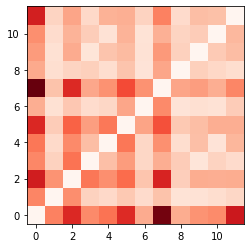

In [22]:
before = loudest_in_runs[:, :-1]
after = loudest_in_runs[:, 1:]

fig, ax = plt.subplots(1, 1)
ax.hist2d(
    np.asarray(ak.flatten(before)),
    np.asarray(ak.flatten(after)),
    bins=(12, 12),
    range=((-0.5, 11.5), (-0.5, 11.5)),
    cmap="Reds",
)
ax.set_aspect(1)

In [94]:
interval_numbers = loudest_in_runs[:, :-1] + 12 * loudest_in_runs[:, 1:]

In [95]:
interval_numbers

<Array [[69, 113, 93, 7, ... 115, 57, 88, 79]] type='1000 * var * ?int64'>

In [97]:
numbers_to_match = ak.Array(np.arange(144))[np.newaxis, np.newaxis, :]

In [98]:
intervals_per_song = ak.mean(interval_numbers == numbers_to_match, axis=1)

In [100]:
np_intervals_per_song = np.asarray(intervals_per_song)

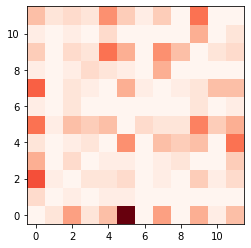

In [107]:
before = loudest_in_runs[0, :-1]
after = loudest_in_runs[0, 1:]

fig, ax = plt.subplots(1, 1)
ax.hist2d(
    np.asarray((before)),
    np.asarray((after)),
    bins=(12, 12),
    range=((-0.5, 11.5), (-0.5, 11.5)),
    cmap="Reds",
)
ax.set_aspect(1)

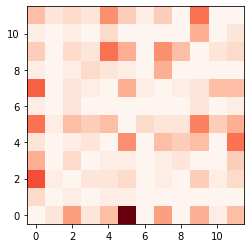

In [109]:
plt.imshow(np_intervals_per_song[0].reshape(12, 12), origin="lower", cmap="Reds")

In [110]:
import sklearn.cluster

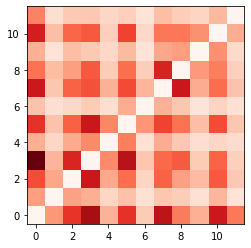

0.04 William Shatner_ David Itkin_ The Arkansas Symphony Orchestra_ Paul Rowe: Exodus: Part I: Moses and Pharaoh
0.05 The Association: Ron's Reverie: Across The Field / Carmen Ohio (Album Version)
0.05 Sonny Rollins Quartet: Paul's Pal
0.05 Howard Armstrong: My Four Reasons
0.06 Osanna: Oro Caldo
0.06 The Four Preps: The Big Draft Medley
0.06 Kitty Margolis: Midnight Sun
0.06 The Shadow Ring: Crystal Tears
0.06 Aretha Franklin: RUNNIN' OUT OF FOOLS
0.06 Chick Corea / Béla Fleck: Sunset Road


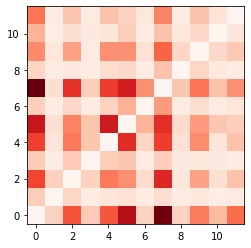

0.06 Halle/Hughes: Valse Triste (Kuolema Op 44)
0.06 Francis Dunnery: Too Much Saturn
0.07 Earl Anderza: You'd Be So Nice To Come Home To (1998 Digital Remaster)
0.07 Erskine Hawkins and His Orchestra: Let's Go Home
0.07 Xavier Cugat: Amor_ Amor_ Amor
0.07 Miguel Gallardo: Eternamente Amame
0.07 Sebastian: Bear With Me
0.07 The Corrs: Love Gives Love Takes ( LP Version )
0.07 Stuff Smith: C Jam Blues
0.07 Bud Powell: Embraceable You


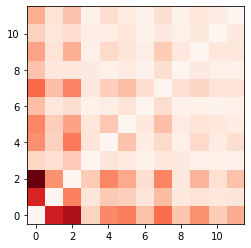

0.07 Olle Adolphson: Tatuerarevalsen (remaster '03)
0.07 Lil Johnson: Love Thief
0.08 Smartbomb: Complicate It
0.08 Alejandro Sanz: Corazon Partio Club Mix Edit
0.08 Chuck Loeb: New Life
0.08 Los Rieleros Del Norte: Usted
0.08 The Verve Pipe: Medicate Myself
0.08 Camilo Sesto: Llueve Sobre Mojado
0.08 Jam Hsiao: Green Door
0.08 Gary Hobbs: The Look Of Love


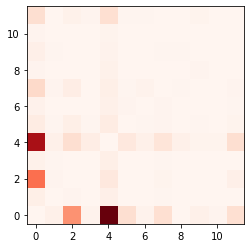

0.13 Public Image Ltd: (This Is Not A) Love Song (Live)
0.14 Taras: I Will Love Again (JJ's Club Radio)
0.17 Mike Shiver: Feelings
0.17 Explicit Samouraï: X.plicit sentence
0.2 Polygon Window: Quino-Phec
0.26 Trees of mint: And so on...
0.3 The Tyrant Lizard Kings: Delete All Alarms


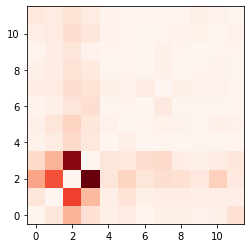

0.09 Maxi Priest: Groovin' In The Midnight
0.1 Lady Sovereign: Bang Bang
0.11 Aphex Twin: Come On You Slags
0.11 Ec8or: Cocain Ducks
0.12 Primal Scream: Pills
0.13 Coldfeet: Shamefaced (Francois K Dub Mix)
0.13 DJ X-Change featuring DJ Joey A: Come Over
0.14 Tassilli Players: Interstellar Overdub
0.14 Scenario Rock: Perfect Love Antidote BoBmo First Remix
0.14 Nine Inch Nails: The Frail


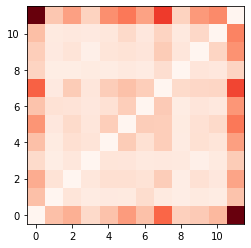

0.07 Faiz Ali Faiz: Sohna Nee Sohna Data
0.08 The Berzerker: Deform (live)
0.08 Flux of Pink Indians: Take Heed
0.08 Lorena: Footloose
0.08 The Babys: Love Is Just A Mystery
0.08 Barbara McNair: The Shadow Of Your Smile
0.08 Flor Silvestre: Caricia Y Herida
0.09 Stretch Arm Strong: Pursuit Of Happiness
0.09 Deadlock: We Shall All Bleed
0.09 Rocola Bacalao: Jose Garbanzo


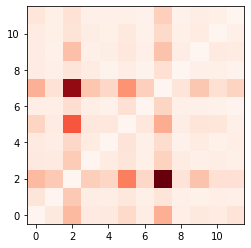

0.08 Napalm Death: The World Keeps Turning
0.08 Scred Connexion: Freestyle 35 (feat. Les Spécialistes)
0.09 Chuck Loeb: The Music Inside
0.09 Damien Dempsey: Industrial School
0.09 Saratoga: Semillas de odio
0.09 Hildegard Knef: Gestern hab' ich noch nachgedacht (Live)
0.09 Organized Konfusion: Hate
0.09 Blue Rodeo: Floating
0.09 Lonnie Mack: Down In The Dumps  (LP Version)
0.09 Van Halen: Panama (Remastered Album Version)


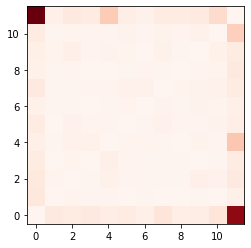

0.09 Dru Down: Rock It Don't Stop It
0.09 Borialis: Hourglass
0.1 Riccardo Fogli: Sulla buona strada
0.11 Jazz Addixx: Say Jazzy
0.11 Massimo Volume: La Notte Dell'11 Ottobre
0.12 Discofamily: It Just Won't Do
0.13 Carl Cox Vs Yousef: I Want You (Forever)
0.13 Kevin Gordon: Marina Takes Her Aim
0.13 Top Billin: My Girl Wants
0.14 Axel Karakasis: Hands In The Pocket


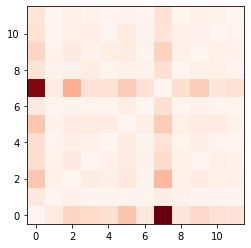

0.07 Toby Lightman: One Day
0.07 Bob Neuwirth: Biding Her Time
0.08 Frank Reyes: Ya No Te Creo Nada
0.08 Doctor Butcher: Freaks
0.08 Merle Haggard And The Strangers: Folsom Prison Blues
0.09 Chris Brashear: Little Home In Tennessee
0.09 Solistiyhtye Suomi: Teräslintu
0.09 Jeff And Sheri Easter: The Moon And I (Ordinary Day Album Version)
0.09 Jacob Miller: Mixed Up Moods
0.09 Rory Block: Three Is a Crowd


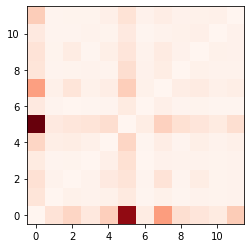

0.06 DJ Dips: Gerra De De
0.07 Jolin Tsai: Le Yuan (OT:They)
0.08 Jacob Young: In A Subtle Way
0.09 GNR: Toxicidade
0.09 Charlie Feathers: Frankie & Johnny
0.1 The B-52's: Wig
0.1 Sofia Talvik: Arms and Armour
0.1 Nick Cave & The Bad Seeds: She Fell Away (2009 Digital Remaster)
0.11 Golden Boots: Buildings
0.11 Terry Winchell: Crazy Some


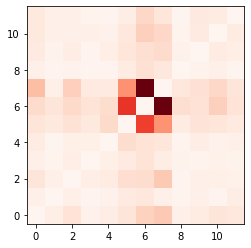

0.08 Med Flory: Bamboo
0.09 Paul Johnson: Just Dance!
0.1 The Devil Wears Prada: Danger: Wildman
0.11 Keith Urban: Everybody
0.11 Iwer George: Jump & Dunk
0.11 Ghostface Killah: Assassination Day
0.12 Foo Fighters: Hell
0.12 Joy Lynn White: The Lucky Few
0.12 Badly Drawn Boy: Tickets To What You Need
0.12 The Weathermen: Let Them Come To Berlin


In [218]:
model = sklearn.cluster.AgglomerativeClustering(distance_threshold=0.75, n_clusters=None).fit(np_intervals_per_song)
unique_labels = np.unique(model.labels_)

centers = []
for label in unique_labels:
    centers.append(np.mean(np_intervals_per_song[model.labels_ == label], axis=0).reshape(12, 12))
    
for center, label in zip(centers, unique_labels):
    plt.imshow(center, origin="lower", cmap="Reds")
    plt.show()
    distances = np.sqrt(np.sum((np_intervals_per_song[model.labels_ == label] - center.reshape(-1))**2, axis=1))
    sorter = np.argsort(distances)
    sorted_song_metadata = some_songs[model.labels_ == label, "metadata", ["artist_name", "title"]][sorter]
    for artist_title, dist in zip(sorted_song_metadata[:10].tolist(), distances[sorter][:10]):
        print(round(dist, 2), artist_title["artist_name"] + ": " + artist_title["title"])

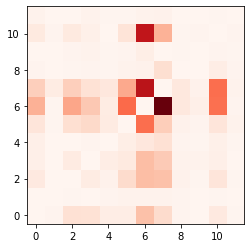

In [215]:
plt.imshow(np_intervals_per_song[some_songs.metadata.title == "Just Dance!"][0].reshape(12, 12), origin="lower", cmap="Reds")

# Scale-up

In [ ]:
collect_intervals_per_song = []

def doit(some_songs):
    shift_for_song = key_shift[some_songs.analysis.key]
    shifted_pitches = some_songs.analysis.segments.pitches[shift_for_song[:, np.newaxis]]
    loudest_pitches = ak.argmax(shifted_pitches, axis=-1)
    before = loudest_pitches[:, :-1]
    after = loudest_pitches[:, 1:]
    segment_new_loudest = ak.concatenate([True, before != after], axis=1)
    segment_loudest_change = ak.local_index(shifted_pitches, axis=1)[segment_new_loudest]
    run_length = segment_loudest_change[:, 1:] - segment_loudest_change[:, :-1]
    last_run = ak.num(shifted_pitches) - ak.sum(run_length, axis=-1)
    full_run_length = ak.concatenate([ak.fill_none(run_length, 0), last_run[:, np.newaxis]], axis=1)
    grouped_by_same_loudest = ak.unflatten(ak.flatten(shifted_pitches), ak.flatten(full_run_length))
    mean_in_each_group = ak.mean(grouped_by_same_loudest, axis=1)
    pitches_in_runs = ak.unflatten(mean_in_each_group, ak.num(full_run_length))
    loudest_in_runs = ak.argmax(pitches_in_runs, axis=-1)
    interval_numbers = loudest_in_runs[:, :-1] + 12 * loudest_in_runs[:, 1:]
    numbers_to_match = ak.Array(np.arange(144))[np.newaxis, np.newaxis, :]
    intervals_per_song = ak.mean(interval_numbers == numbers_to_match, axis=1)
    np_intervals_per_song = np.asarray(intervals_per_song)
    collect_intervals_per_song.append(np_intervals_per_song)

begin = time.time()
for partnum, partition in enumerate(songs.layout.partitions):
    doit(ak.Array(partition))
    print(partnum, "out of", len(songs.layout.partitions), "in", time.time() - begin, "seconds")